In [1]:
import open3d as o3d
import numpy as np
import math, pandas, pickle
import scipy
from scipy import sparse
from sklearn.neighbors import KDTree
from sklearn.metrics.pairwise import euclidean_distances
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.dtm_rips_complex import DTMRipsComplex
from ripser import ripser
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from gudhi.tensorflow import RipsLayer
import plotly.graph_objects as go
import ot.plot
import matplotlib.pylab as pl
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from utilyze import *
import pickle
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [23]:
random_seed()
# Raw data is downloaded from '# https://gitlab.com/alexpieloch/PersistentHomologyAnalysisofBrainArteryTrees/-/tree/master/data/OriginalBrainTreeData'

# To save computation time, first subsample 98 point clouds, each consisting of 2000 points.
# Then compute the ICP-Wasserstein distance matrix for these 98 point clouds.
# For each point cloud X, find the ICP-Wasserstein-closest point cloud Y. Compute the difference vector (estimated gradient).
# Subsample 3 point clouds from X and the corresponding gradient vectors.

# Load data
data_pc = np.load("Data/data_pc.pkl", allow_pickle=True)
print('Original pointcloud size:',data_pc[0].shape)
# Subsample
number_pts = 2000 
data_pc_subsample = []
for i in range(len(data_pc)):
    if i not in [40, 45]:
        pc = data_pc[i]
        all_idx = np.random.permutation(pc.shape[0])
        for j in range(1):
            small_idx = all_idx[int(j * number_pts) : int((j+1) * number_pts)]
            pc_sub = pc[small_idx]
            # normalize
            centered_pc_sub = np.copy(pc_sub)
            centered_pc_sub[:,0] -= np.mean(pc_sub[:,0])
            centered_pc_sub[:,1] -= np.mean(pc_sub[:,1])
            centered_pc_sub[:,2] -= np.mean(pc_sub[:,2])
            data_pc_subsample.append(centered_pc_sub)
data_pc = data_pc_subsample
# Normalize
mean_max = np.mean([np.max(abs(data_pc[i]),axis=0) for i in range(len(data_pc))])
for i in range(len(data_pc)):
    data_pc[i] /= mean_max * 2
print('Randomness check: [88916 11866 12750 14216 86734]',  all_idx[:5])
print('Number of data: ',len(data_pc))
print('Sampled pc size: ',data_pc[0].shape)

# Load sex features
df = pandas.read_csv('Data/label.csv')
gender = np.array(df['gender'])
label = []
for i in range(gender.shape[0]):
    if i not in [48,50,63,66,69,72,78,84,98,101,103]:
        label.append(gender[i])
labels_raw=np.array(label)
labels_raw -= 1
labels = []
for i in range(len(labels_raw)):
    if i not in [40, 45]:
        label_pc = labels_raw[i]
        for j in range(1):
            labels.append(label_pc)
labels = np.array(labels)

Original pointcloud size: (116361, 3)
Randomness check: [88916 11866 12750 14216 86734] [88916 11866 12750 14216 86734]
Number of data:  96
Sampled pc size:  (2000, 3)


In [3]:
# compute the ICP-Wasserstein distance matrix
n = len(data_pc)
distance_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i, n):
        pc1,pc2 = data_pc[i],data_pc[j]
        pc1_regis = find_align(pc1, pc2)
        M = ot.dist(pc1_regis, pc2)
        d1,d2 = np.ones((number_pts,)) / number_pts, np.ones((number_pts,)) / number_pts
        emd = ot.emd(d1,d2,M, numItermax=1e6) #default numItermax 1e5
        W = np.sum(emd * M)
        distance_matrix[i][j] = W
        distance_matrix[j][i] = W

In [4]:
# Gradient estimate
data_grad = []
data_pc_real = []
number_pts_real = 500
for i,pc in enumerate(data_pc):
    # find the neareast pc with diff label
    label = labels[i]
    index_otherclass = np.where(labels!=label)[0]
    distances_otherclass = np.array([distance_matrix[i, j] for j in index_otherclass])
    j = index_otherclass[np.argmin(distances_otherclass)]
    # find the OT vector
    pc1 = data_pc[i]
    pc2 = data_pc[j]
    pc1_regis = find_align(pc1, pc2)
    M = ot.dist(pc1_regis, pc2)
    n = pc1_regis.shape[0]
    d1,d2 = np.ones((n,)) / n, np.ones((n,)) / n
    emd = ot.emd(d1,d2,M)
    indices = np.argwhere(emd == np.max(emd))
    vec = [pc2[l] - pc1_regis[k] for k, l in indices]
    vec = np.array(vec)
    random_seed()
    all_idx = np.random.permutation(pc1_regis.shape[0])
    for iter in range(3):
        small_idx = all_idx[number_pts_real*iter: number_pts_real*(iter+1)]
        pc_real = pc1_regis[small_idx]
        vec_real = vec[small_idx]
        vec_real = np.array(vec_real).reshape(-1,)
        data_grad.append(vec_real)
        data_pc_real.append(pc_real)

data_pc = data_pc_real

In [5]:
# Spectrum plots

minisize = len(data_pc)

xrange = [0., .25]
yrange = [0., .15]
maximum_edge_length = .25
gauss_sigma =  1e-4
number_pixel = 20
number_pixels = np.array([5, 10, 20, 30]).astype(np.int32)
colors = plt.cm.get_cmap('viridis', len(number_pixels))
Means = []
Stds = []
for i, number_pixel in enumerate(number_pixels):
    weightfunc = Weight(method='linear', b=1.)
    jacobians, _, _ = Collect_jacobian_and_rank_and_pi(data_pc[:minisize], get_jacobian_rips, xrange, yrange,
                                                       number_pixel=number_pixel, gauss_sigma=gauss_sigma, 
                                                       weight_func=weightfunc, max_edge_length=maximum_edge_length, 
                                                       homology_dimensions=[1], normalize=False)
    specs = []
    for J in jacobians:
        singularvalues = scipy.linalg.svd(J)[1]
        singularvalues /= np.max(singularvalues)
        specs.append(singularvalues)
    specs = np.array(specs)
    mean = np.mean(specs, axis=0)
    std = np.std(specs, axis=0)
    Means.append(mean)
    Stds.append(std)
Means1 = Means
Stds1 = Stds


xrange = [0., .25]
yrange = [0., .15]
maximum_edge_length = .25
gauss_sigma = 1e-4
number_pixel = 20
gauss_sigmas = np.array([1e-7, 1e-5, 1e-4, 1e-3]).astype(np.float32) #0.0001
colors = plt.cm.get_cmap('viridis', len(gauss_sigmas))
Means = []
Stds = []
for i, gauss_sigma in enumerate(gauss_sigmas):
    weightfunc = Weight(method='linear', b=1.)
    jacobians, _, _ = Collect_jacobian_and_rank_and_pi(data_pc[:minisize], get_jacobian_rips, xrange, yrange,
                                                       number_pixel=number_pixel, gauss_sigma=gauss_sigma, 
                                                       weight_func=weightfunc, max_edge_length=maximum_edge_length, 
                                                       homology_dimensions=[1], normalize=False)
    specs = []
    for J in jacobians:
        singularvalues = scipy.linalg.svd(J)[1]
        singularvalues /= np.max(singularvalues)
        specs.append(singularvalues)
    specs = np.array(specs)
    mean = np.mean(specs, axis=0)
    std = np.std(specs, axis=0)
    Means.append(mean)
    Stds.append(std)
Means2 = Means
Stds2 = Stds

2023-07-05 16:56:46.771039: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


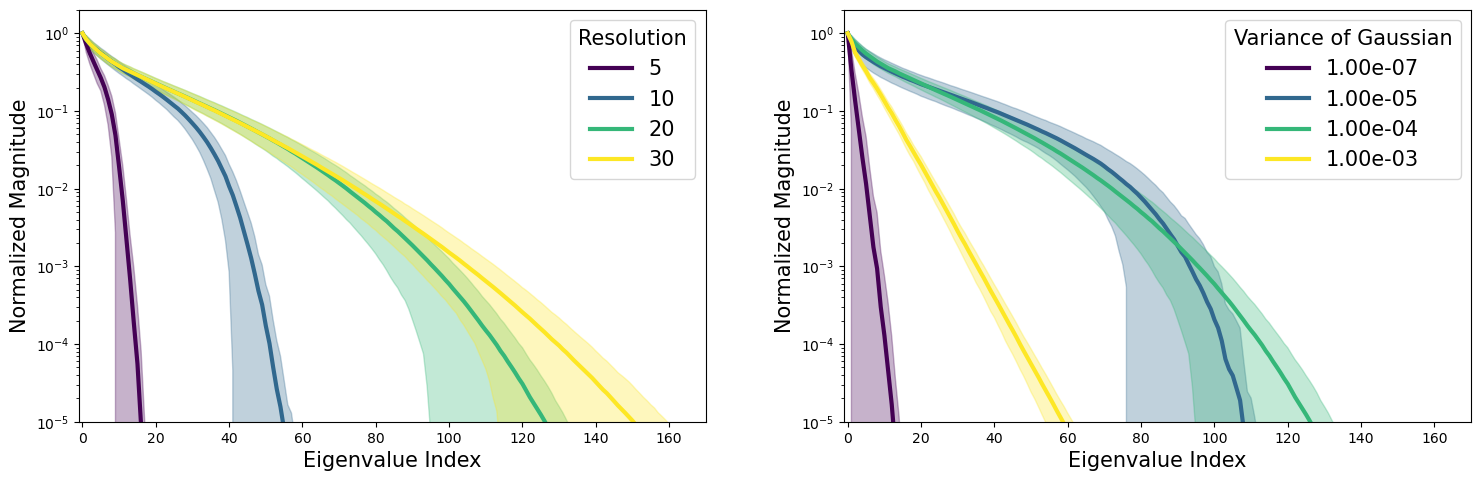

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
gauss_sigma =  1e-4
number_pixel = 20
FZ = 15
max_x = 170
min_y = 1e-5
number_pixels = np.array([5, 10, 20, 30]).astype(np.int32)
colors = plt.cm.get_cmap('viridis', len(number_pixels))
for i, number_pixel in enumerate(number_pixels):
    mean = Means1[i]
    std = Stds1[i]
    ax[0].plot(range(len(mean)), mean, color=colors(i), label=f'{number_pixel}', linewidth=3)
    ax[0].fill_between(range(len(mean)), mean - std, mean + std, color=colors(i), alpha=0.3)
ax[0].set_yscale('log')
ax[0].set_ylabel('Normalized Magnitude', fontsize=FZ)
ax[0].set_xlabel('Eigenvalue Index', fontsize=FZ)
ax[0].set_xlim([-1,max_x])
ax[0].set_ylim([min_y,2.])
ax[0].legend(fontsize=FZ,title='Resolution')
plt.setp(ax[0].get_legend().get_title(), fontsize=FZ) # for legend title

gauss_sigma = 1e-4
number_pixel = 20

gauss_sigmas = np.array([1e-7, 1e-5, 1e-4, 1e-3]).astype(np.float32) #0.0001
colors = plt.cm.get_cmap('viridis', len(gauss_sigmas))
for i, gauss_sigma in enumerate(gauss_sigmas):
    mean = Means2[i]
    std = Stds2[i]   
    ax[1].plot(range(len(mean)), mean, color=colors(i), label=f'{gauss_sigma:.2e}', linewidth=3)
    ax[1].fill_between(range(len(mean)), mean - std, mean + std, color=colors(i), alpha=0.3)
ax[1].set_yscale('log')
ax[1].set_ylabel('Normalized Magnitude', fontsize=FZ)
ax[1].set_xlabel('Eigenvalue Index', fontsize=FZ)
ax[1].set_xlim([-1,max_x])
ax[1].set_ylim([min_y,2.])
ax[1].legend(fontsize=FZ,title='Variance of Gaussian')
plt.setp(ax[1].get_legend().get_title(), fontsize=FZ) # for legend title

plt.tight_layout(pad=5.0)
plt.savefig('Figures/spec_brain.png',dpi=300)

In [6]:
# compute pull-back norms (estimated 1484 miniutes)

xrange = [.0, .25]
yrange = [-.05, .2]
maximum_edge_length = .25
gauss_sigmas = np.linspace(1e-5, 1e-4, 8)
number_pixels = [15, 20, 25, 30]

Pbn = {}
Rank = {}
for number_pixel in number_pixels:
    Pbn[number_pixel] = {}
    Rank[number_pixel] = {}
    for gauss_sigma in gauss_sigmas:
        Pbn[number_pixel][gauss_sigma] = []
        Rank[number_pixel][gauss_sigma] = []


random_seed()
minisize = len(data_pc)
idx = np.random.permutation(len(data_pc))[:minisize]

for number_pixel in number_pixels:
    for gauss_sigma in gauss_sigmas:
        random_seed()
        weightfunc = Weight(method='linear', b=yrange[1])
        jacobians, pis, ranks = Collect_jacobian_and_rank_and_pi(np.array(data_pc)[idx], get_jacobian_rips, xrange, yrange,
                                                number_pixel=number_pixel, gauss_sigma=gauss_sigma, 
                                                weight_func = weightfunc, max_edge_length=maximum_edge_length, 
                                                homology_dimensions=[1], normalize=False, normalize_jac=True)
        
        grads = np.array(data_grad)[idx]
        assert len(grads)==len(jacobians)
        Pbn[number_pixel][gauss_sigma] = [np.linalg.norm(jacobians[k] @ grads[k]) for k in range(len(grads))]
        Rank[number_pixel][gauss_sigma] = ranks


2023-07-04 09:22:37.978392: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
# downstream performance
df = pandas.read_csv('Data/label.csv')
gender = np.array(df['gender'])
label = []
for i in range(gender.shape[0]):
    if i not in [48,50,63,66,69,72,78,84,98,101,103]:
        label.append(gender[i])
labels_raw=np.array(label)
#print(np.where(labels_raw==3))
#print(np.where(labels_raw==4))
labels_raw -= 1

labels = []
for i in range(len(labels_raw)):
    if i not in [40, 45]: # remove label 3, 4
        label_pc = labels_raw[i]
        for j in range(3):
            labels.append(label_pc)        
labels = np.array(labels)

In [8]:
from sklearn.metrics import log_loss

def train_lr(train_data, train_labels, val_data, val_labels, noise_level = .01, C=1):
    random_seed()
    lr = LogisticRegression(max_iter=300, C=C) #solver
    lr.fit(train_data, train_labels)
    test_accuracy = accuracy_score(val_labels, lr.predict(val_data))
    test_loss = log_loss(val_labels, lr.predict_proba(val_data))
    train_accuracy = accuracy_score(train_labels, lr.predict(train_data))
    train_loss = log_loss(train_labels, lr.predict_proba(train_data))
    #robust test
    val_data_noisy = val_data + np.random.normal(0,noise_level, size = val_data.shape)
    robust_test_loss = log_loss(val_labels, lr.predict_proba(val_data_noisy))
    robust_test_accuracy = accuracy_score(val_labels, lr.predict(val_data_noisy))
    return train_loss, train_accuracy, test_loss, test_accuracy, robust_test_loss, robust_test_accuracy

def train_cnn(train_data, train_labels, val_data, val_labels, noise_level=.01, epochs=10, batch_size=32):
    random_seed()
    # Define the CNN model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(train_data.shape[1], train_data.shape[2], 1)),
        tf.keras.layers.MaxPooling2D((2, 2)), 
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(train_data, train_labels,
                        validation_data=(val_data, val_labels),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)
    # Evaluate the model on test data
    train_loss, train_accuracy = model.evaluate(train_data, train_labels, verbose=0)
    test_loss, test_accuracy = model.evaluate(val_data, val_labels, verbose=0)
    # Robust test
    val_data_noisy = val_data + np.random.normal(0,noise_level, size = val_data.shape)
    robust_test_loss, robust_test_accuracy = model.evaluate(val_data_noisy, val_labels, verbose=0)
    return train_loss, train_accuracy, test_loss, test_accuracy, robust_test_loss, robust_test_accuracy

In [9]:
xrange = [.0, .25]
yrange = [-.05, .2]
maximum_edge_length = .25

gauss_sigmas = np.linspace(1e-5, 1e-4, 8)
number_pixels = [15, 20, 25, 30]

random_seed()
Testacc = {}
Robustacc = {}
Testacc_cnn = {}
Robustacc_cnn = {}

for number_pixel in number_pixels:
    Testacc[number_pixel] = {}
    Robustacc[number_pixel] = {}
    Testacc_cnn[number_pixel] = {}
    Robustacc_cnn[number_pixel] = {}
    for gauss_sigma in gauss_sigmas:
        Testacc[number_pixel][gauss_sigma] = []
        Robustacc[number_pixel][gauss_sigma] = []
        Testacc_cnn[number_pixel][gauss_sigma] = []
        Robustacc_cnn[number_pixel][gauss_sigma] = []

random_seed()
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(n_splits=7)

for number_pixel in number_pixels:
    for gauss_sigma in gauss_sigmas:
        random_seed()
        weightfunc = Weight(method='linear', b=yrange[1])
        data_pi = Collect_pi(data_pc, xrange, yrange, number_pixel=number_pixel, gauss_sigma=gauss_sigma, weight_func = weightfunc, max_edge_length=maximum_edge_length, homology_dimensions=[1], normalize=False)            
        data_pi /= np.max(data_pi) # normalize feature <-> normal jac
        
        #Logistic
        for train_index, test_index in kf.split(data_pi):
            train_pi, val_pi = data_pi[train_index], data_pi[test_index]
            train_labels, val_labels = labels[train_index], labels[test_index]
            train_loss, train_accuracy, test_loss, test_accuracy, robust_test_loss, robust_test_accuracy = train_lr(train_pi, train_labels, val_pi, val_labels, C=1)
            Testacc[number_pixel][gauss_sigma].append(test_accuracy)
            Robustacc[number_pixel][gauss_sigma].append(robust_test_accuracy)

        #CNN
        data_image = data_pi.reshape(len(data_pi), number_pixel,number_pixel)
        for train_index, test_index in kf.split(data_image):
            train_pi, val_pi = data_image[train_index], data_image[test_index]
            train_labels, val_labels = labels[train_index], labels[test_index]
            train_loss, train_accuracy, test_loss, test_accuracy, robust_test_loss, robust_test_accuracy = train_cnn(train_pi, train_labels, val_pi, val_labels)
            Testacc_cnn[number_pixel][gauss_sigma].append(test_accuracy)
            Robustacc_cnn[number_pixel][gauss_sigma].append(robust_test_accuracy)


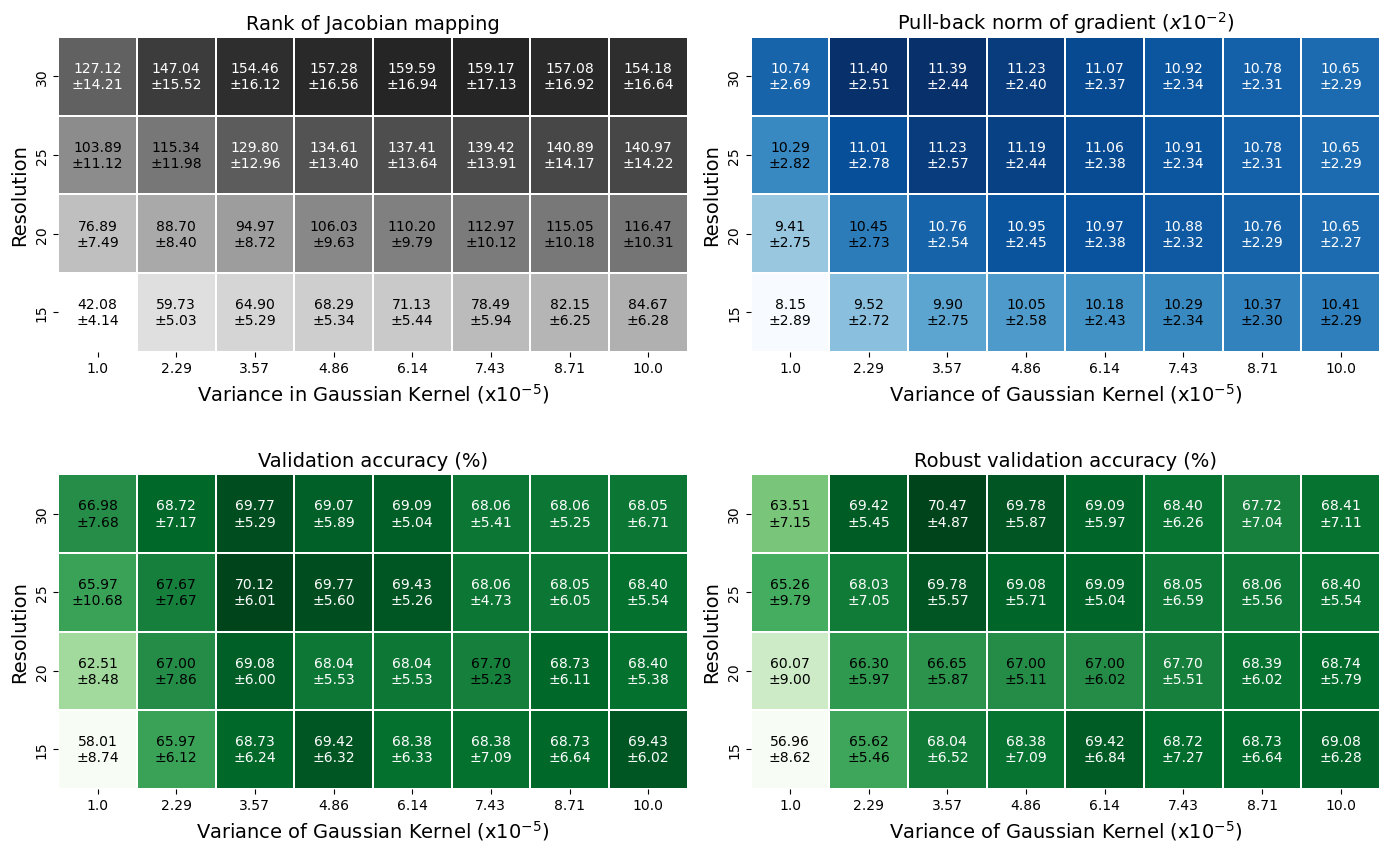

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
dictionaries = [Pbn, Rank]
titles = ['Pullback norm','Rank']
cmaps = ['Blues','Greys']
gauss_sigmas = np.linspace(1e-5, 1e-4, 8)
number_pixels = [15, 20, 25, 30]
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(14, 9))
fmts = ['.3f','.1f']
gauss_sigmas_label = np.round(gauss_sigmas * 1e5 * 1e2)/1e2
FS = 14
dictionary = Rank
mean = [[np.mean(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
mean = np.flip(np.array(mean), axis=0)
sd = [[np.std(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
sd = np.flip(np.array(sd), axis=0)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ffffff","#252525"])
ax = sns.heatmap(mean, annot=False, cmap=cmap, linewidths=.1, ax=axes[0,0],square=True, cbar=False)

ax.set_yticklabels(np.flip(number_pixels, axis=0))
ax.set_xticklabels(gauss_sigmas_label)
ax.set_title("Rank of Jacobian mapping", fontsize=FS)
ax.set_ylabel('Resolution', fontsize=FS)
ax.set_xlabel('Variance in Gaussian Kernel (x$10^{-5}$)', fontsize=FS)

for i in range(mean.shape[0]):
    for j in range(mean.shape[1]):
        value = mean[i, j]
        std_error = sd[i, j]
        annotation_text = "{:.2f}\n±{:.2f}".format(value, std_error)
        pixel_color = mean[i][j]
        annotation_color = 'black' if pixel_color < 1.1 * np.mean(mean) else 'white'
        ax.text(j + 0.5, i + 0.5, annotation_text, ha='center', va='center', color=annotation_color, fontsize=10)
dictionary = Pbn
mean = [[np.mean(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
mean = np.flip(np.array(mean), axis=0)
sd = [[np.std(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
sd = np.flip(np.array(sd), axis=0)
ax = sns.heatmap(mean, annot=False, cmap='Blues', linewidths=.1, ax=axes[0,1],square=True, cbar=False)
ax.set_yticklabels(np.flip(number_pixels, axis=0))
ax.set_xticklabels(gauss_sigmas_label)
ax.set_title("Pull-back norm of gradient ($ x 10^{-2}$)", fontsize=FS)
ax.set_ylabel('Resolution', fontsize=FS)
ax.set_xlabel('Variance of Gaussian Kernel (x$10^{-5}$)', fontsize=FS)
for i in range(mean.shape[0]):
    for j in range(mean.shape[1]):
        value = mean[i, j]*100
        std_error = sd[i, j]*100
        annotation_text = "{:.2f}\n±{:.2f}".format(value, std_error)
        pixel_color = mean[i][j]
        annotation_color = 'black' if pixel_color < 1 * np.mean(mean) else 'white'
        ax.text(j + 0.5, i + 0.5, annotation_text, ha='center', va='center', color=annotation_color, fontsize=10)
###
dictionary = Testacc
mean = [[ np.mean(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
mean = np.flip(np.array(mean), axis=0)
sd = [[ np.std(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
sd = np.flip(np.array(sd), axis=0)
ax = sns.heatmap(mean, annot=False, cmap='Greens', linewidths=.1, ax=axes[1,0], square=True, cbar=False)
ax.set_yticklabels(np.flip(number_pixels, axis=0))
ax.set_title('Validation accuracy (%)', fontsize=FS)
ax.set_xticklabels(gauss_sigmas_label)
ax.set_ylabel('Resolution', fontsize=FS)
ax.set_xlabel('Variance of Gaussian Kernel (x$10^{-5}$)', fontsize=FS)
for i in range(mean.shape[0]):
    for j in range(mean.shape[1]):
        value = mean[i, j] *100
        std_error = sd[i, j] *100
        annotation_text = "{:.2f}\n±{:.2f}".format(value, std_error)
        pixel_color = mean[i][j]
        annotation_color = 'black' if pixel_color < 1 * np.mean(mean) else 'white'
        ax.text(j + 0.5, i + 0.5, annotation_text, ha='center', va='center', color=annotation_color, fontsize=10)
dictionary = Robustacc
mean = [[ np.mean(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
mean = np.flip(np.array(mean), axis=0)
sd = [[ np.std(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
sd = np.flip(np.array(sd), axis=0)
ax = sns.heatmap(mean, annot=False, cmap='Greens', linewidths=.1, ax=axes[1,1], square=True, cbar=False)
ax.set_yticklabels(np.flip(number_pixels, axis=0))
ax.set_title('Robust validation accuracy (%)', fontsize=FS)
ax.set_xticklabels(gauss_sigmas_label)
ax.set_ylabel('Resolution', fontsize=FS)
ax.set_xlabel('Variance of Gaussian Kernel (x$10^{-5}$)', fontsize=FS)
for i in range(mean.shape[0]):
    for j in range(mean.shape[1]):
        value = mean[i, j] *100
        std_error = sd[i, j] *100
        annotation_text = "{:.2f}\n±{:.2f}".format(value, std_error)
        pixel_color = mean[i][j]
        annotation_color = 'black' if pixel_color < 1.0 * np.mean(mean) else 'white'
        ax.text(j + 0.5, i + 0.5, annotation_text, ha='center', va='center', color=annotation_color, fontsize=10)
plt.tight_layout()
plt.savefig('Figures/resvar.png',dpi=300)

In [11]:
import pickle

gauss_sigmas = np.linspace(1e-5, 1e-4, 8)
number_pixels = [15, 20, 25, 30]

dictionary = Pbn
mean = [[np.mean(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
acc_list = np.array(mean).reshape(-1)
a = acc_list
pbn_list = (a - np.min(a)) / (np.max(a) - np.min(a))

dictionary = Testacc
mean = [[np.mean(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
acc_list = np.array(mean).reshape(-1)
a = acc_list
acc_list = (a - np.min(a)) / (np.max(a) - np.min(a))

dictionary = Robustacc
mean = [[np.mean(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
rob_acc_list = np.array(mean).reshape(-1)
a = rob_acc_list
rob_acc_list = (a - np.min(a)) / (np.max(a) - np.min(a))

dictionary = Rank
mean = [[np.mean(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
rank_list = np.array(mean).reshape(-1)
a = np.array(mean).reshape(-1)
rank_list = (a - np.min(a)) / (np.max(a) - np.min(a))

dictionary = Testacc_cnn
mean = [[np.mean(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
a = np.array(mean).reshape(-1)
acc_list_cnn = (a - np.min(a)) / (np.max(a) - np.min(a))

dictionary = Robustacc_cnn
mean = [[np.mean(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
a = np.array(mean).reshape(-1)
rob_acc_list_cnn = (a - np.min(a)) / (np.max(a) - np.min(a))


In [12]:
# PCC and pvalue for logistic regressions

from scipy.stats import pearsonr
correlation_coeff, p_value = pearsonr(pbn_list, acc_list)
print(correlation_coeff, p_value)

correlation_coeff, p_value = pearsonr(pbn_list, rob_acc_list)
print(correlation_coeff, p_value)

correlation_coeff, p_value = pearsonr(rank_list, acc_list)
print(correlation_coeff, p_value)

correlation_coeff, p_value = pearsonr(rank_list, rob_acc_list)
print(correlation_coeff, p_value)

0.812923823419397 1.5811011176128175e-08
0.7753393353272263 1.878408084138492e-07
0.4811797643207235 0.00530303021400248
0.5063694021501668 0.003104971502000653


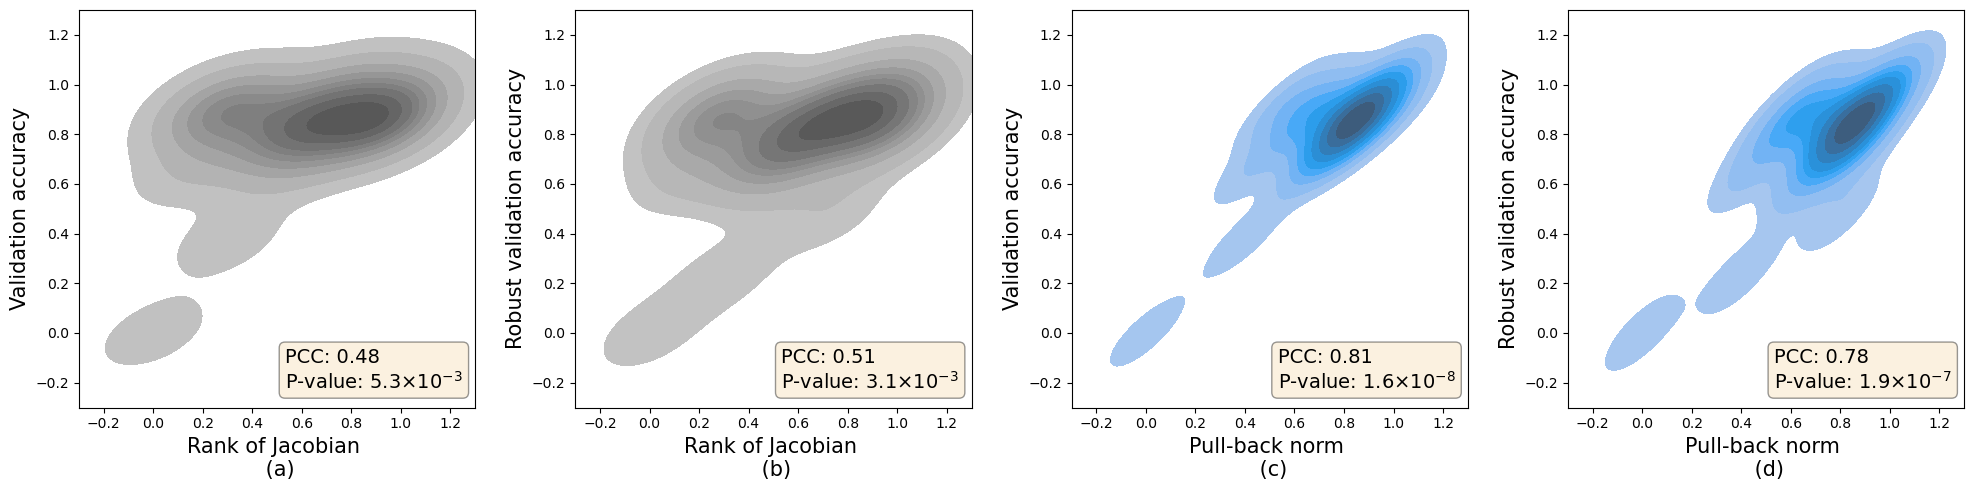

In [16]:
fig, axs = plt.subplots(1,4,figsize=(20,5))

sns.kdeplot(x=rank_list, y=acc_list,fill=True,ax=axs[0],color='gray',thresh=.05)
axs[0].set_xlabel('Rank of Jacobian \n (a)',fontsize=15)
axs[0].set_ylabel('Validation accuracy',fontsize=15)
axs[0].set_xlim([-0.3, 1.3])
axs[0].set_ylim([-0.3, 1.3])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
textstr = 'PCC: 0.48 \n'+r'P-value: 5.3$\times 10^{-3}$'
axs[0].text(0.52, 0.15, textstr, transform=axs[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)

sns.kdeplot(x=rank_list, y=rob_acc_list,fill=True,ax=axs[1],color='gray',thresh=.05)
axs[1].set_xlabel('Rank of Jacobian \n (b)',fontsize=15)
axs[1].set_ylabel('Robust validation accuracy',fontsize=15)
axs[1].set_xlim([-0.3, 1.3])
axs[1].set_ylim([-0.3, 1.3])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
textstr = 'PCC: 0.51 \n'+r'P-value: 3.1$\times 10^{-3}$'
axs[1].text(0.52, 0.15, textstr, transform=axs[1].transAxes, fontsize=14, verticalalignment='top', bbox=props)

sns.kdeplot(x=pbn_list, y=acc_list,fill=True,ax=axs[2], thresh=.05)
axs[2].set_xlabel('Pull-back norm \n (c)',fontsize=15)
axs[2].set_ylabel('Validation accuracy',fontsize=15)
axs[2].set_xlim([-0.3, 1.3])
axs[2].set_ylim([-0.3, 1.3])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
textstr = 'PCC: 0.81 \n'+r'P-value: 1.6$\times 10^{-8}$'
axs[2].text(0.52, 0.15, textstr, transform=axs[2].transAxes, fontsize=14, verticalalignment='top', bbox=props)



sns.kdeplot(x=pbn_list, y=rob_acc_list,fill=True,ax=axs[3],thresh=.05)
axs[3].set_xlabel('Pull-back norm \n (d)',fontsize=15)
axs[3].set_ylabel('Robust validation accuracy',fontsize=15)
axs[3].set_xlim([-0.3, 1.3])
axs[3].set_ylim([-0.3, 1.3])

props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
textstr = 'PCC: 0.78 \n'+r'P-value: 1.9$\times 10^{-7}$'
axs[3].text(0.52, 0.15, textstr, transform=axs[3].transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('Figures/correlation.png',dpi=300)

In [14]:
# PCC and pvalue for CNNs

correlation_coeff, p_value = pearsonr(pbn_list, acc_list_cnn)
print(correlation_coeff, p_value)

correlation_coeff, p_value = pearsonr(pbn_list, rob_acc_list_cnn)
print(correlation_coeff, p_value)

correlation_coeff, p_value = pearsonr(rank_list, acc_list_cnn)
print(correlation_coeff, p_value)

correlation_coeff, p_value = pearsonr(rank_list, rob_acc_list_cnn)
print(correlation_coeff, p_value)

0.7503981251451637 7.590108031303458e-07
0.7204199657594863 3.3301389730684804e-06
0.8241350063492738 6.7780532421307405e-09
0.7345150864180106 1.7025170906694908e-06


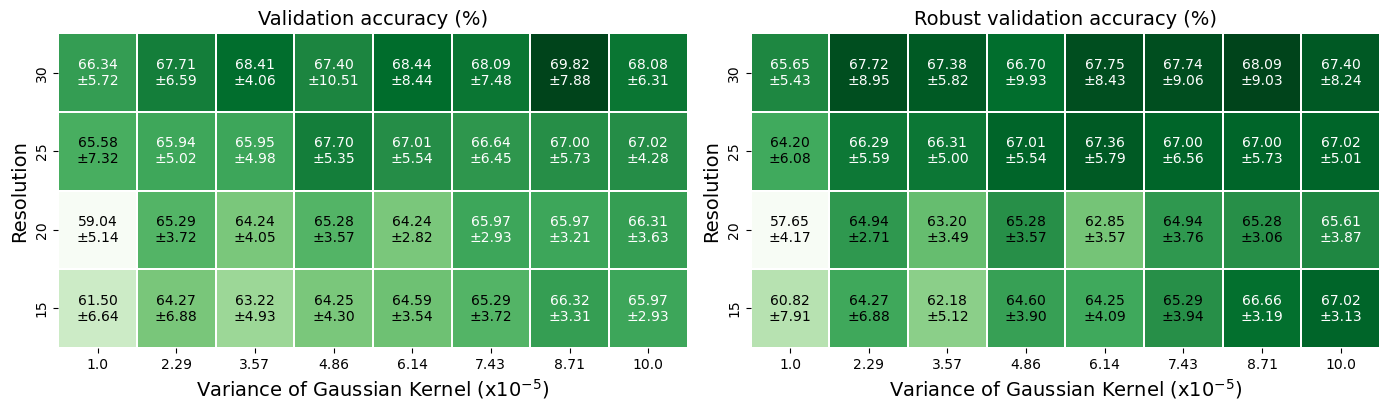

In [20]:
# CNN performance

dictionaries = [Pbn, Rank]
titles = ['Pullback norm','Rank']
cmaps = ['Blues','Greys']
gauss_sigmas = np.linspace(1e-5, 1e-4, 8)
number_pixels = [15, 20, 25, 30]
rows = 1
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(14, 4.5))
fmts = ['.3f','.1f']
gauss_sigmas_label = np.round(gauss_sigmas * 1e5 * 1e2)/1e2
FS = 14
###
dictionary = Testacc_cnn
mean = [[ np.mean(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
mean = np.flip(np.array(mean), axis=0)
sd = [[ np.std(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
sd = np.flip(np.array(sd), axis=0)
ax = sns.heatmap(mean, annot=False, cmap='Greens', linewidths=.1, ax=axes[0], square=True, cbar=False)
ax.set_yticklabels(np.flip(number_pixels, axis=0))
ax.set_title('Validation accuracy (%)', fontsize=FS)
ax.set_xticklabels(gauss_sigmas_label)
ax.set_ylabel('Resolution', fontsize=FS)
ax.set_xlabel('Variance of Gaussian Kernel (x$10^{-5}$)', fontsize=FS)
for i in range(mean.shape[0]):
    for j in range(mean.shape[1]):
        value = mean[i, j] *100
        std_error = sd[i, j] *100
        annotation_text = "{:.2f}\n±{:.2f}".format(value, std_error)
        pixel_color = mean[i][j]
        annotation_color = 'black' if pixel_color < 1 * np.mean(mean) else 'white'
        ax.text(j + 0.5, i + 0.5, annotation_text, ha='center', va='center', color=annotation_color, fontsize=10)
dictionary = Robustacc_cnn
mean = [[ np.mean(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
mean = np.flip(np.array(mean), axis=0)
sd = [[ np.std(dictionary[key][sub_key]) for sub_key in gauss_sigmas] for key in number_pixels]
sd = np.flip(np.array(sd), axis=0)
ax = sns.heatmap(mean, annot=False, cmap='Greens', linewidths=.1, ax=axes[1], square=True, cbar=False)
ax.set_yticklabels(np.flip(number_pixels, axis=0))
ax.set_title('Robust validation accuracy (%)', fontsize=FS)
ax.set_xticklabels(gauss_sigmas_label)
ax.set_ylabel('Resolution', fontsize=FS)
ax.set_xlabel('Variance of Gaussian Kernel (x$10^{-5}$)', fontsize=FS)
for i in range(mean.shape[0]):
    for j in range(mean.shape[1]):
        value = mean[i, j] *100
        std_error = sd[i, j] *100
        annotation_text = "{:.2f}\n±{:.2f}".format(value, std_error)
        pixel_color = mean[i][j]
        annotation_color = 'black' if pixel_color < 1.0 * np.mean(mean) else 'white'
        ax.text(j + 0.5, i + 0.5, annotation_text, ha='center', va='center', color=annotation_color, fontsize=10)

plt.tight_layout()
plt.savefig('Figures/resvar_cnn.png',dpi=300)

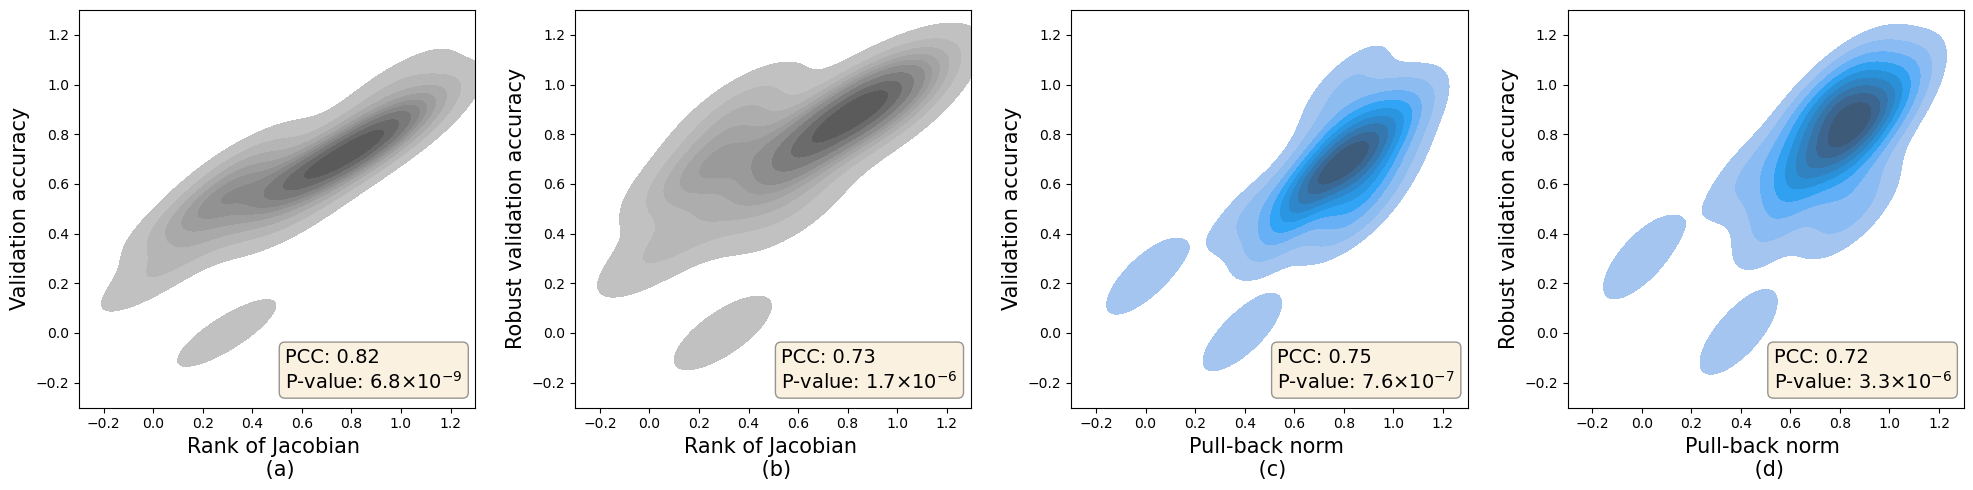

In [17]:
fig, axs = plt.subplots(1,4,figsize=(20,5))

sns.kdeplot(x=rank_list, y=acc_list_cnn,fill=True,ax=axs[0],color='gray',thresh=.05)
axs[0].set_xlabel('Rank of Jacobian \n (a)',fontsize=15)
axs[0].set_ylabel('Validation accuracy',fontsize=15)
axs[0].set_xlim([-0.3, 1.3])
axs[0].set_ylim([-0.3, 1.3])
ax = axs[0]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
textstr = 'PCC: 0.82 \n'+r'P-value: 6.8$\times 10^{-9}$'
ax.text(0.52, 0.15, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)



sns.kdeplot(x=rank_list, y=rob_acc_list_cnn,fill=True,ax=axs[1],color='gray',thresh=.05)
axs[1].set_xlabel('Rank of Jacobian \n (b)',fontsize=15)
axs[1].set_ylabel('Robust validation accuracy',fontsize=15)
axs[1].set_xlim([-0.3, 1.3])
axs[1].set_ylim([-0.3, 1.3])
ax = axs[1]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
textstr = 'PCC: 0.73 \n'+r'P-value: 1.7$\times 10^{-6}$'
ax.text(0.52, 0.15, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


sns.kdeplot(x=pbn_list, y=acc_list_cnn,fill=True,ax=axs[2], thresh=.05)
axs[2].set_xlabel('Pull-back norm \n (c)',fontsize=15)
axs[2].set_ylabel('Validation accuracy',fontsize=15)
axs[2].set_xlim([-0.3, 1.3])
axs[2].set_ylim([-0.3, 1.3])
ax = axs[2]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
textstr = 'PCC: 0.75 \n'+r'P-value: 7.6$\times 10^{-7}$'
ax.text(0.52, 0.15, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


sns.kdeplot(x=pbn_list, y=rob_acc_list_cnn,fill=True,ax=axs[3],thresh=.05)
axs[3].set_xlabel('Pull-back norm \n (d)',fontsize=15)
axs[3].set_ylabel('Robust validation accuracy',fontsize=15)
axs[3].set_xlim([-0.3, 1.3])
axs[3].set_ylim([-0.3, 1.3])
ax = axs[3]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.4)
textstr = 'PCC: 0.72 \n'+r'P-value: 3.3$\times 10^{-6}$'
ax.text(0.52, 0.15, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('Figures/correlation_cnn.png',dpi=300)

